### 1)

In [120]:
# Given code to generate the random triples

import numpy as np
import ctypes
import numba as nb
import time
from matplotlib import pyplot as plt

mylib=ctypes.cdll.LoadLibrary("libc.dylib")
rand=mylib.rand
rand.argtypes=[]
rand.restype=ctypes.c_int

@nb.njit
def get_rands_nb(vals):
    n=len(vals)
    for i in range(n):
        vals[i]=rand()
    return vals

def get_rands(n):
    vec=np.empty(n,dtype='int32')
    get_rands_nb(vec)
    return vec

n=300000000
vec=get_rands(n*3)
#vv=vec&(2**16-1)

vv=np.reshape(vec,[n,3])
vmax=np.max(vv,axis=1)

maxval=1e8
vv2=vv[vmax<maxval,:]

f=open('rand_points.txt','w')
for i in range(vv2.shape[0]):
    myline=repr(vv2[i,0])+' '+repr(vv2[i,1])+' '+ repr(vv2[i,2])+'\n'
    f.write(myline)
f.close()

30238
[0.42798974 0.43431301]


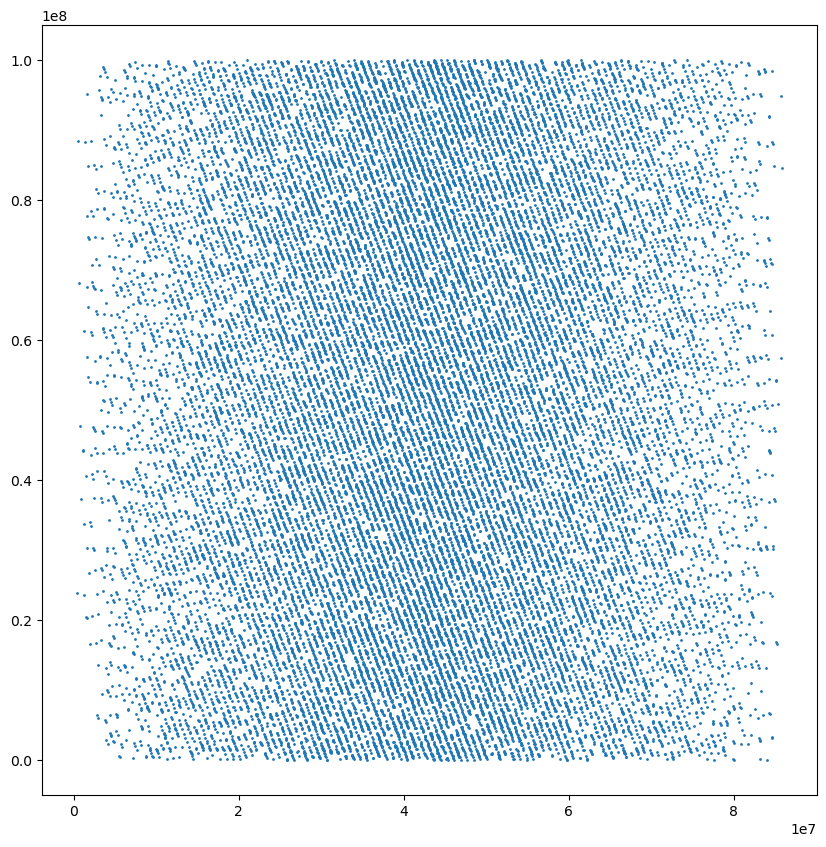

In [147]:
from scipy.optimize import curve_fit
data=np.loadtxt('rand_points.txt')
print(len(data))

def plane(data,a,b):
    x=data[:,0]
    y=data[:,1]
    return(a*x+b*y)

popt,pcov=curve_fit(plane,data,data[:,2])
print(popt)

a=popt[0]
b=popt[1]

plt.figure(figsize=(10,10))
plt.scatter(plane(data,a,b),data[:,2],s=1)

Clearly the points lie along some rather small number of planes.

In [156]:
# Generate random triples with python now

import random

n=10000000
vec=np.empty(n*3,dtype='int32')
for i in range(n*3):
    vec[i]=random.randint(0,sys.maxsize)
    if(i%10000==0):
        print('Progress: {}%'.format(np.round((i/(n*3))*100,1)), end="\r", flush=True)

vv=np.reshape(vec,[n,3])
vmax=np.max(vv,axis=1)

maxval=1e8
vv2=vv[vmax<maxval,:]

[0.4129878 0.4208622]


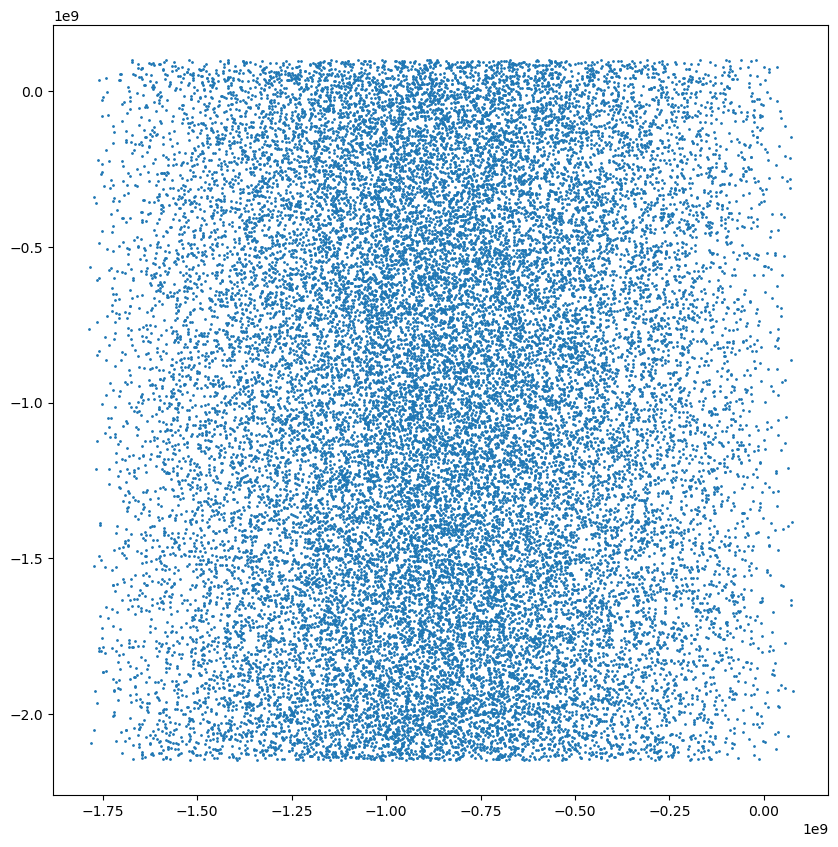

In [157]:
data=vv2[:30000]

def plane(data,a,b):
    x=data[:,0]
    y=data[:,1]
    return(a*x+b*y)

popt,pcov=curve_fit(plane,data,data[:,2])
print(popt)

a=popt[0]
b=popt[1]

plt.figure(figsize=(10,10))
plt.scatter(plane(data,a,b),data[:,2],s=1)

Using python's random int generator, there is no readily apparent correlation between the numbers unlike C's rand().

In [164]:
mylib=ctypes.cdll.LoadLibrary("libSystem.dylib")
rand=mylib.rand
rand.argtypes=[]
rand.restype=ctypes.c_int

@nb.njit
def get_rands_nb(vals):
    n=len(vals)
    for i in range(n):
        vals[i]=rand()
    return vals

def get_rands(n):
    vec=np.empty(n,dtype='int32')
    get_rands_nb(vec)
    return vec

n=300000000
vec=get_rands(n*3)
#vv=vec&(2**16-1)

vv=np.reshape(vec,[n,3])
vmax=np.max(vv,axis=1)

maxval=1e8
vv2=vv[vmax<maxval,:]

[0.42794588 0.43164077]


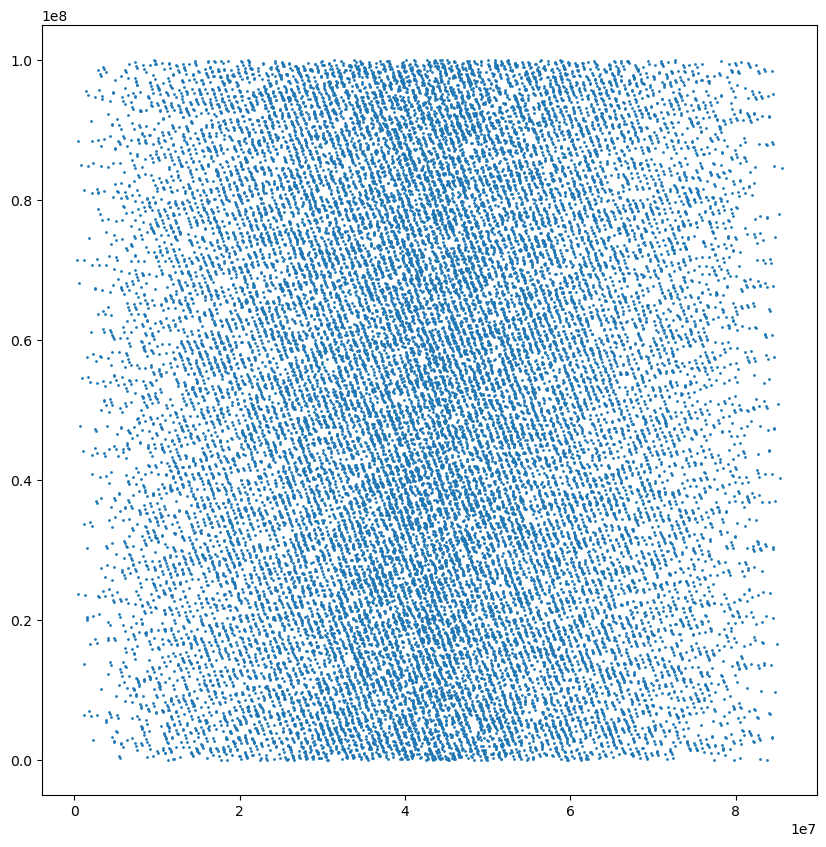

In [165]:
data=vv2

def plane(data,a,b):
    x=data[:,0]
    y=data[:,1]
    return(a*x+b*y)

popt,pcov=curve_fit(plane,data,data[:,2])
print(popt)

a=popt[0]
b=popt[1]

plt.figure(figsize=(10,10))
plt.scatter(plane(data,a,b),data[:,2],s=1)

Using my local random int generator, seems to have the same problem as C but maybe to a lesser extent. 

### 2)

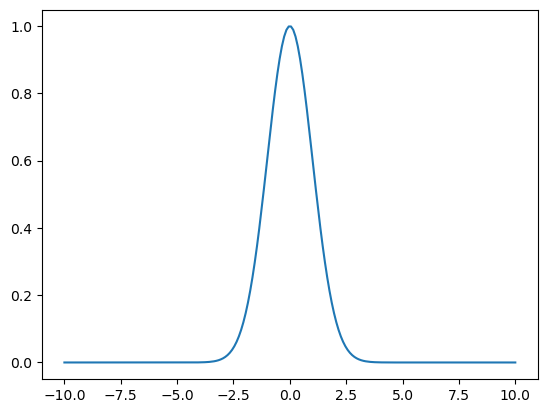

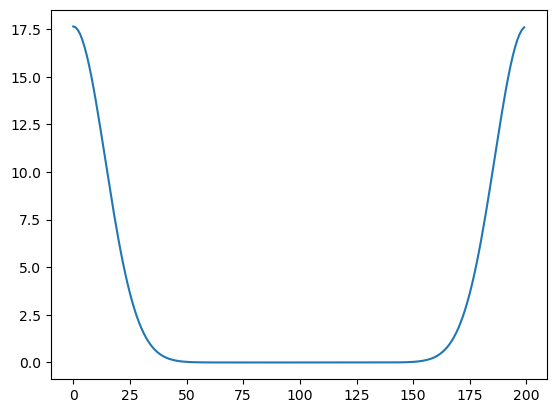

In [40]:
def correlation(f,g):
    return np.fft.irfft(np.fft.rfft(f)*np.conj(np.fft.rfft(g)))

plt.plot(x,gauss)
plt.show()
plt.plot(correlation(gauss,gauss))

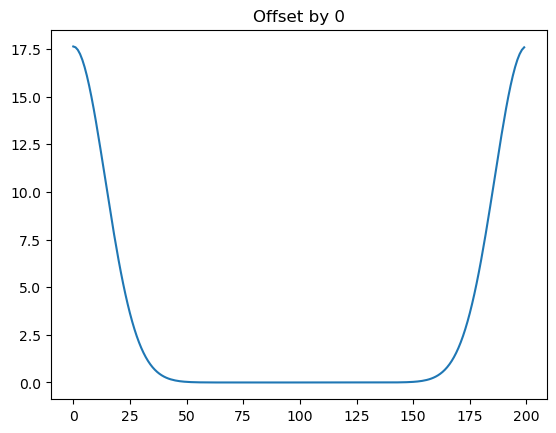

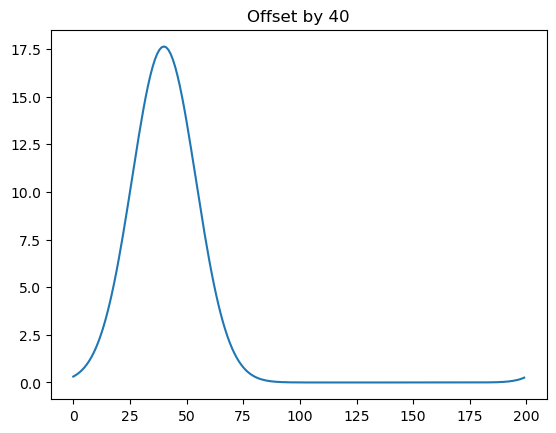

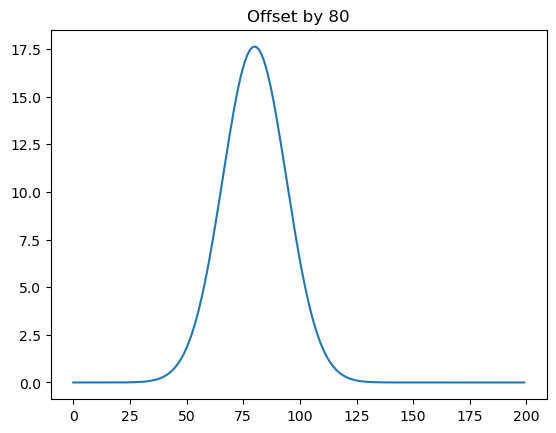

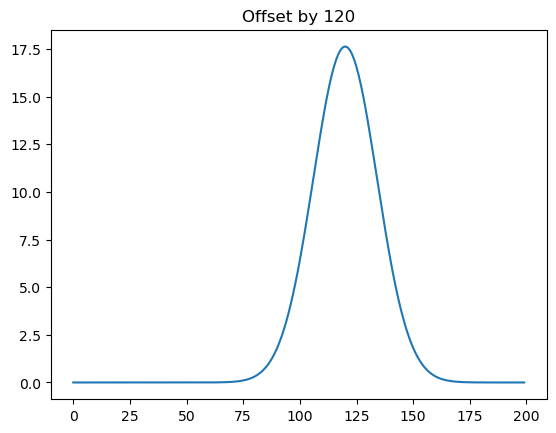

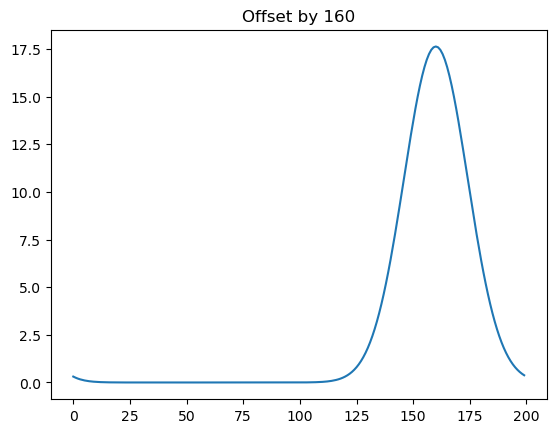

In [38]:
shifts=[i*N//5 for i in range(5)]
for s in shifts:
    plt.plot(correlation(gauss,shift(gauss,s)))
    plt.title('Offset by {}'.format(s))
    plt.show()

Correlation function looks like gaussian centered at offset value. Makes sense as that is where the gaussians would match up exactly and so that is where the peak is. 

### 3)

Convolution just like correlation but no longer take conjugate. Periodic nature of the dft means it will result in circural convolution. To achieve convolution without wrapping around, need to pad end of arrays with zeros to sufficient length since the zeros will not affect when they wrap.

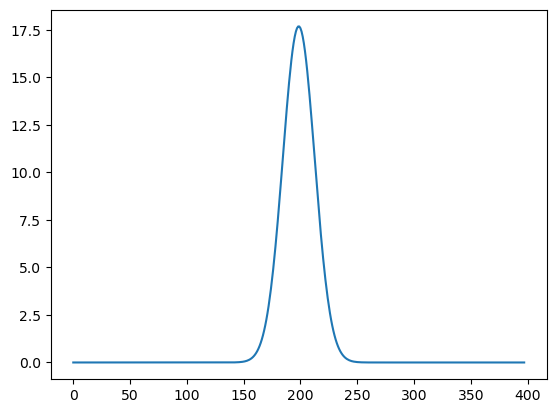

In [66]:
def conv_lin(f,g):
    f_len=len(f)
    g_len=len(g)
    f=np.pad(f,(0,g_len-1))
    g=np.pad(g,(0,f_len-1))
    return np.fft.irfft(np.fft.rfft(f)*np.fft.rfft(g))

conv_gauss=conv_lin(gauss,gauss)

plt.plot(conv_gauss)
plt.show()

### 4)

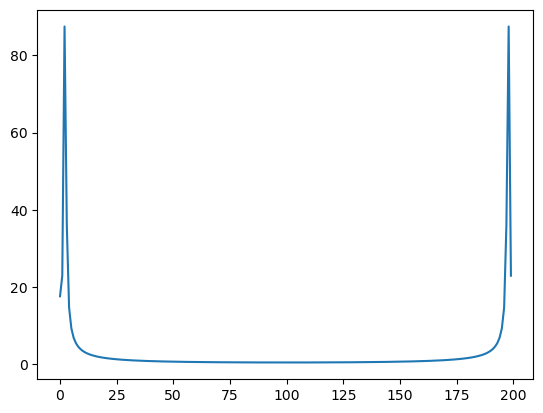

In [126]:
def analytic_dft(a,N):
    x=np.arange(N)
    k=np.expand_dims(np.arange(N),1)
    series=(1/(2j))*(np.exp(-2j*np.pi*(k-a)*x/N)-np.exp(-2j*np.pi*(k+a)*x/N))
    return(np.sum(series,axis=1))

N=200
k=2.3
plt.plot(np.abs(analytic_dft(k,N)))

Roughly appears to be two delta functions, as predicted, with right side one being negative frequency of first. Spectral leakage can be seen as they are not perfect delta peaks, instead some neighbouring k having none 0 amplitude.

In [127]:
# Compare to fft

x=np.arange(N)
f=np.sin(2*np.pi*k*x/N)
dft=np.fft.fft(f)

print("Diff:",np.std(dft-analytic_dft(k,N)))

Diff: 2.6010622579320535e-13


The two methods agree.

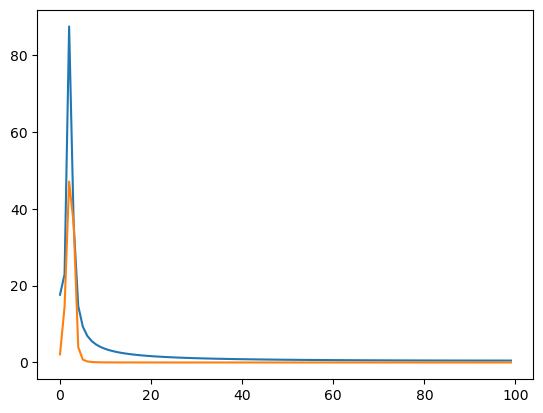

In [128]:
window=0.5-0.5*np.cos(2*np.pi*x/N)
window_f=window*f
window_dft=np.fft.fft(window_f)
plt.plot(np.abs(dft[:N//2]))
plt.plot(np.abs(window_dft[:N//2]))

After multiplying by window, peak seems to be narrower so is closer to the delta function we expect.

In [129]:
N=5
x=np.arange(N)
window=0.5-0.5*np.cos(2*np.pi*x/N)
print(np.real(np.fft.fft(window)))

[ 2.50000000e+00 -1.25000000e+00 -1.11022302e-16 -1.11022302e-16
 -1.25000000e+00]


Diff: 1.0762066761904083e-15


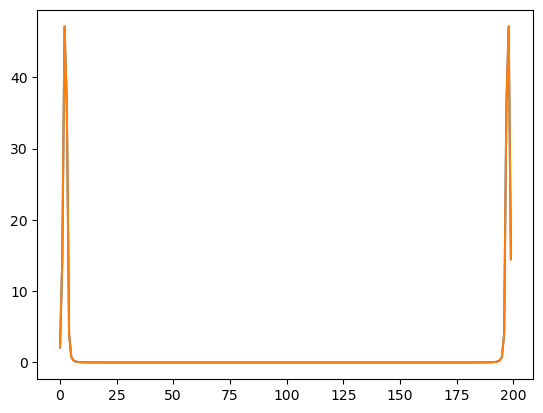

In [156]:
N=200
x=np.arange(N)
f=np.sin(2*np.pi*k*x/N)
dft=np.fft.fft(f)
window=0.5-0.5*np.cos(2*np.pi*x/N)
window_f=window*f
window_dft=np.fft.fft(window_f)

def analytic_window_dft(dft):
    N=len(dft)
    temp=np.zeros(N,dtype='complex')
    for k in range(N):
        temp[k]=1*((1/2)*dft[k%N]-(1/4)*dft[(k-1)%N]-(1/4)*dft[(k+1)%N])
    return temp

plt.plot(np.abs(window_dft))
plt.plot(np.abs(analytic_window_dft(dft)))
print("Diff:",np.std(np.abs(window_dft)-np.abs(analytic_window_dft(dft))))

As expected, was able to recreate windowed fourier transform using the unwindowed fourier transform. Although had to exclude factor of N, some kind of normalization and maybe forgot to divide by N?